In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

from tqdm.notebook import tqdm

import os
import re
import sys

from xgboost import XGBRegressor, Booster, DMatrix
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Crypto Project/final_new.csv', parse_dates=['Date'], index_col='Date')
df = df.drop("Symbol", axis=1)
df.head()

,Name,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,
2021-07-06,Aave,346.714780,307.997525,307.997525,316.898507,988705452.8,4.066776e+09
2021-07-05,Aave,317.387234,263.433881,277.110533,307.829079,793140860.1,3.950269e+09
2021-07-04,Aave,289.001124,248.285491,259.399426,277.038792,427571943.3,3.555054e+09
2021-07-03,Aave,265.107342,228.485206,234.208478,259.655225,385377799.5,3.331546e+09
2021-07-02,Aave,234.483957,215.951539,230.814119,233.948437,256639522.8,3.001542e+09


In [4]:
coins = df['Name'].unique()
coins

array(['Aave', 'Bitcoin', 'Cardano', 'Chainlink', 'Dogecoin', 'EOS',
       'Ethereum', 'Litecoin', 'Polkadot', 'Stellar', 'Tether', 'Uniswap',
       'USD Coin', 'XRP'], dtype=object)

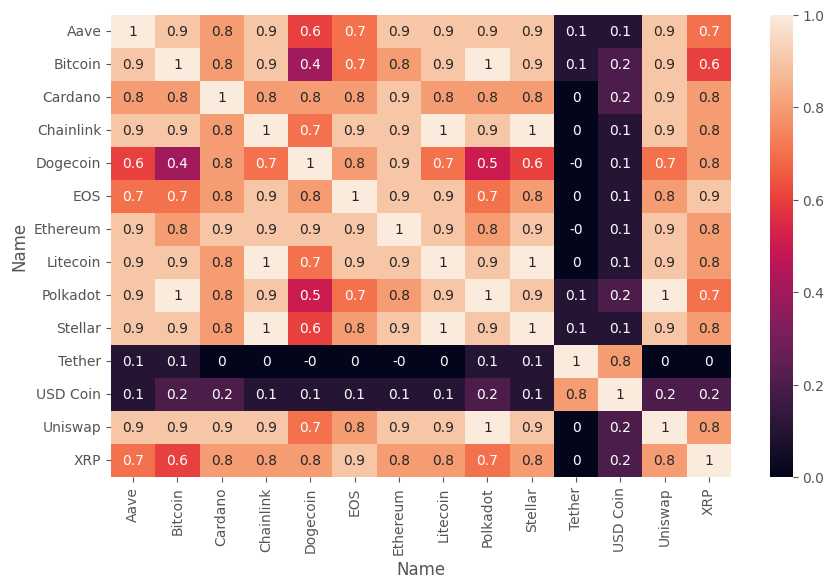

In [5]:
crypto_corr = round((df[['Name', 'Close']].pivot_table(values='Close', index=['Date'], columns=['Name'])).dropna().corr(), 1)
plt.figure(figsize=(10,6))
sns.heatmap(crypto_corr, annot=True);

We know Tether and USDC is a stablecoin which is a type of cryptocurrency. It is a centralized Digital token pegged with fiat currency, hence it don't have correlation with decentralize (real) cryptocurrencies.

In [6]:
def coin_df(Name):
    ''' Get datapoints for a specific coin '''
    temp_df = df[df.Name==Name]
    temp_df = temp_df.sort_index(ascending=False)
    temp_df = temp_df.drop("Name", axis=1)
    temp_df = temp_df[['Close', 'Volume']]
    return temp_df

In [7]:
bitcoin_df = coin_df('Bitcoin')
bitcoin_df.head()

,Close,Volume
Date,,
2021-07-06,34235.19345,2.650126e+10
2021-07-05,33746.00246,2.672155e+10
2021-07-04,35287.77977,2.492431e+10
2021-07-03,34668.54840,2.438396e+10
2021-07-02,33897.04859,3.872897e+10


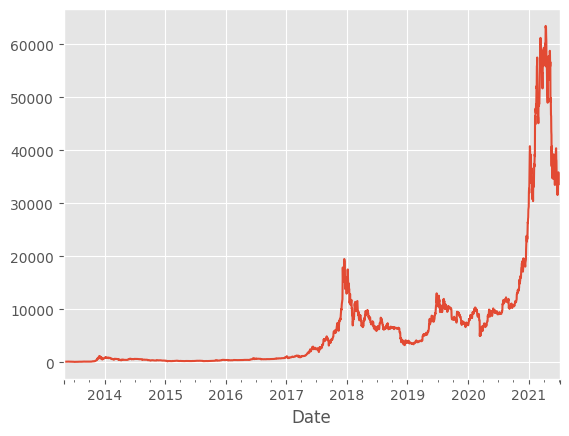

In [ ]:
bitcoin_df['Close'].plot();

# FB Prophet

In [ ]:
!pip install prophet -q

In [ ]:
from prophet import Prophet

In [ ]:
# format needed for Prophet
data = bitcoin_df[['Close']].reset_index().rename(columns={'Date':'ds', 'Close':'y'})
data.head()

,ds,y
0,2021-07-06,34235.19345
1,2021-07-05,33746.00246
2,2021-07-04,35287.77977
3,2021-07-03,34668.54840
4,2021-07-02,33897.04859


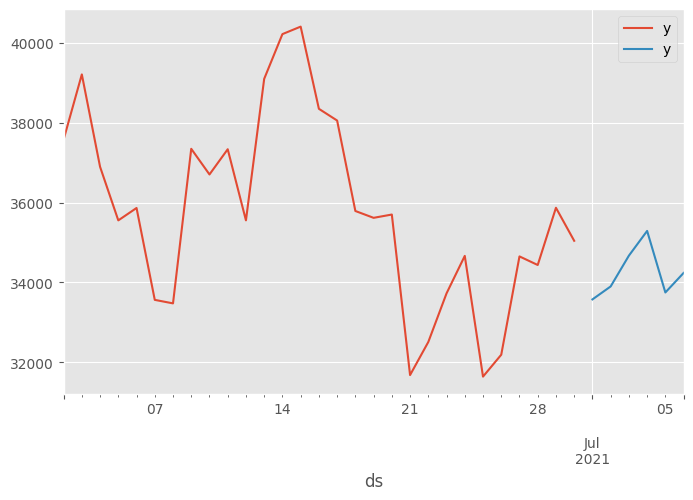

In [ ]:
train = data[((data['ds']>'2021-06-01') & (data['ds']<'2021-07-01'))].reset_index(drop=True) # 1 month
test = data[data['ds']>='2021-07-01'].reset_index(drop=True) # next 6 days

fig, ax = plt.subplots(figsize=(8,5))
train.plot(x='ds', y='y', ax=ax)
test.plot(x='ds', y='y', ax=ax)
plt.show()

In [ ]:
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyj2kyvwf/gdioqfpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyj2kyvwf/b6pb0cvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89545', 'data', 'file=/tmp/tmpyj2kyvwf/gdioqfpe.json', 'init=/tmp/tmpyj2kyvwf/b6pb0cvo.json', 'output', 'file=/tmp/tmpyj2kyvwf/prophet_modelggke5y7q/prophet_model-20230906050754.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [ ]:
predicted = model.predict(test)
predicted

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-01,33896.160709,32361.124587,37467.667356,33896.037547,33896.284510,1043.545637,1043.545637,1043.545637,1043.545637,1043.545637,1043.545637,0.0,0.0,0.0,34939.706346
1,2021-07-02,33768.645603,30711.509569,35800.965443,33768.245775,33769.063982,-568.989697,-568.989697,-568.989697,-568.989697,-568.989697,-568.989697,0.0,0.0,0.0,33199.655907
2,2021-07-03,33641.130498,29989.226138,34914.440543,33640.366137,33641.909035,-1128.321226,-1128.321226,-1128.321226,-1128.321226,-1128.321226,-1128.321226,0.0,0.0,0.0,32512.809272
3,2021-07-04,33513.615393,31431.379500,36623.073654,33512.440728,33514.824464,592.260473,592.260473,592.260473,592.260473,592.260473,592.260473,0.0,0.0,0.0,34105.875866
4,2021-07-05,33386.100288,30325.855122,35232.071584,33384.422242,33387.798493,-632.384775,-632.384775,-632.384775,-632.384775,-632.384775,-632.384775,0.0,0.0,0.0,32753.715513
5,2021-07-06,33258.585182,30684.654888,35904.963241,33256.379574,33260.819345,82.029555,82.029555,82.029555,82.029555,82.029555,82.029555,0.0,0.0,0.0,33340.614738


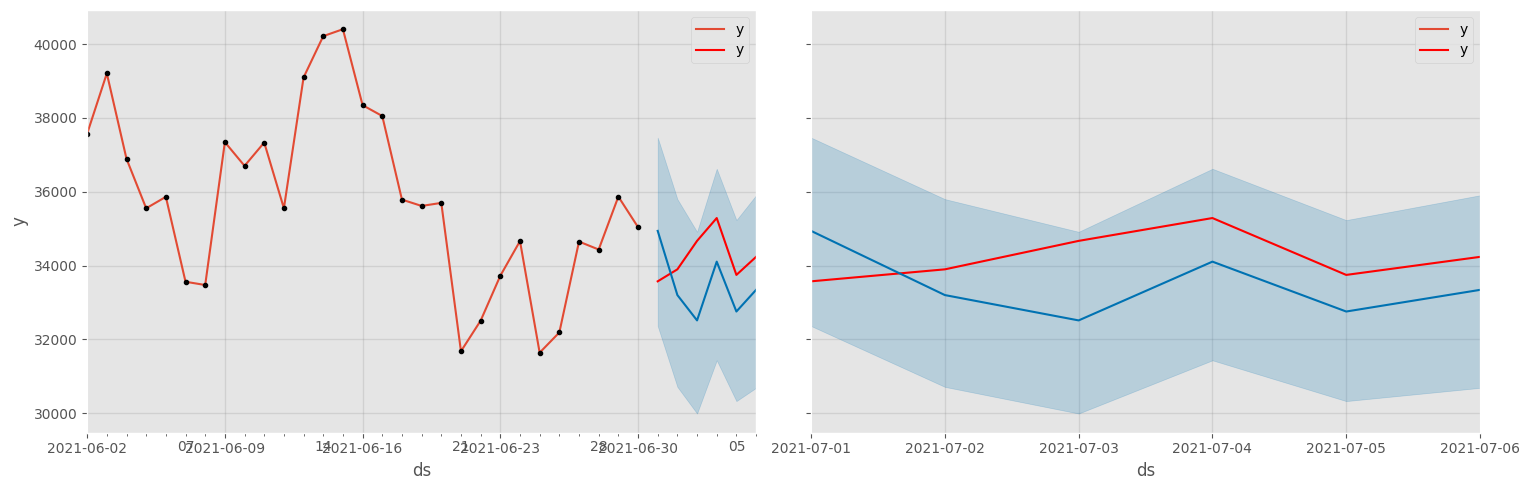

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
train.plot(x='ds', y='y', ax=axs[0])
test.plot(x='ds', y='y', ax=axs[0], color='red')
model.plot(predicted, ax=axs[0])

train.plot(x='ds', y='y', ax=axs[1])
test.plot(x='ds', y='y', ax=axs[1], color='red')
model.plot(predicted, ax=axs[1])
axs[1].set_xbound(lower=datetime.strptime('2021-07-01', '%Y-%m-%d'), upper=datetime.strptime('2021-07-06', '%Y-%m-%d'))
plt.show()

In [ ]:
print("mean_squared_error:",
      round(mean_squared_error(test['y'], predicted['yhat']),2),
      round(mean_squared_error(test['y'], predicted['yhat_lower']),2),
      round(mean_squared_error(test['y'], predicted['yhat_upper']),2))
print("mean_absolute_percentage_error:",
      round(mean_absolute_percentage_error(test['y'], predicted['yhat']),2),
      round(mean_absolute_percentage_error(test['y'], predicted['yhat_lower']),2),
      round(mean_absolute_percentage_error(test['y'], predicted['yhat_upper']),2))
print("root_mean_squared_error:",
      round(np.sqrt(mean_squared_error(test['y'], predicted['yhat'])),2),
      round(np.sqrt(mean_squared_error(test['y'], predicted['yhat_lower'])),2),
      round(np.sqrt(mean_squared_error(test['y'], predicted['yhat_upper'])),2))

mean_squared_error: 1695449.79 12060846.38 4309294.42
mean_absolute_percentage_error: 0.03 0.1 0.06
root_mean_squared_error: 1302.09 3472.87 2075.88


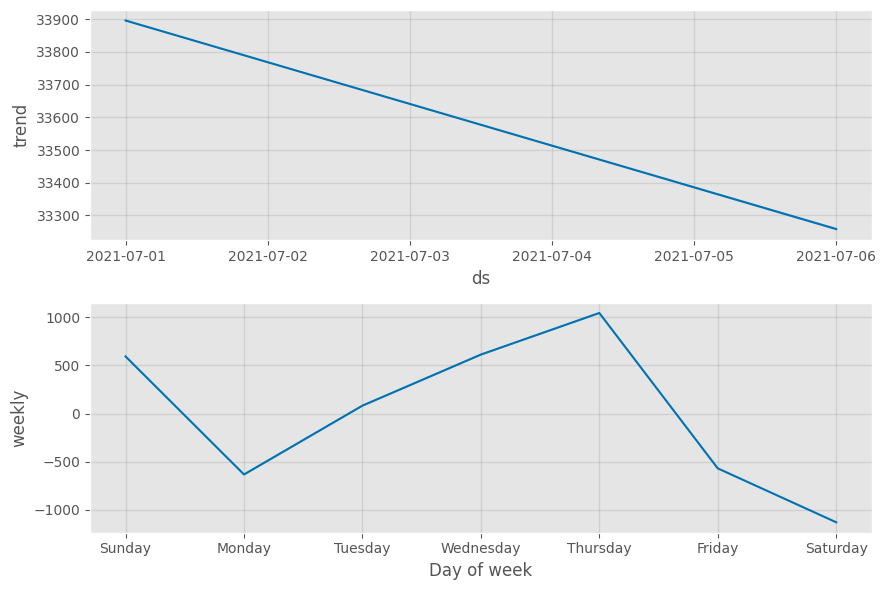

In [ ]:
model.plot_components(predicted);

In [ ]:
# predict on new dates
model.predict(model.make_future_dataframe(periods=6, freq='d', include_history=False))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-01,33896.160709,32427.089869,37375.291593,33896.023684,33896.273030,1043.545637,1043.545637,1043.545637,1043.545637,1043.545637,1043.545637,0.0,0.0,0.0,34939.706346
1,2021-07-02,33768.645603,30760.637799,35597.529676,33768.211561,33769.031660,-568.989697,-568.989697,-568.989697,-568.989697,-568.989697,-568.989697,0.0,0.0,0.0,33199.655907
2,2021-07-03,33641.130498,30095.021990,35240.015736,33640.288738,33641.895821,-1128.321226,-1128.321226,-1128.321226,-1128.321226,-1128.321226,-1128.321226,0.0,0.0,0.0,32512.809272
3,2021-07-04,33513.615393,31605.239240,36675.290114,33512.336282,33514.820630,592.260473,592.260473,592.260473,592.260473,592.260473,592.260473,0.0,0.0,0.0,34105.875866
4,2021-07-05,33386.100288,30116.574922,35353.202332,33384.360080,33387.825865,-632.384775,-632.384775,-632.384775,-632.384775,-632.384775,-632.384775,0.0,0.0,0.0,32753.715513
5,2021-07-06,33258.585182,30875.072742,35911.427026,33256.274059,33260.853088,82.029555,82.029555,82.029555,82.029555,82.029555,82.029555,0.0,0.0,0.0,33340.614738


# XGBoost

In [ ]:
bitcoin_df.head()

,Close,Volume
Date,,
2021-07-06,34235.19345,2.650126e+10
2021-07-05,33746.00246,2.672155e+10
2021-07-04,35287.77977,2.492431e+10
2021-07-03,34668.54840,2.438396e+10
2021-07-02,33897.04859,3.872897e+10


### Feature Engineering

In [ ]:
# def createDateFeatures(data):
#     ''' Date Features '''

#     temp = data.copy()
#     temp['day'] = temp.index.day
#     temp['month'] = temp.index.month
#     temp['year'] = temp.index.year
#     temp['weekofyear'] = temp.index.isocalendar().week.astype('int')
#     temp['weekday'] = temp.index.weekday
#     temp['dayofyear'] = temp.index.day_of_year

#     temp['date_offset'] = (temp.index.month * 100 + temp.index.day - 320) % 1300
#     temp['season'] = pd.cut(temp['date_offset'],
#                             bins=[0, 300, 602, 900, 1300],
#                             labels=['spring', 'summer', 'fall', 'winter'])
#     temp.drop('date_offset', axis=1, inplace=True)

#     temp2 = pd.get_dummies(temp['season'])
#     temp.drop('season', axis=1, inplace=True)
#     temp = temp.merge(temp2, how='left', left_index=True, right_index=True)

#     return temp

In [ ]:
'''
    Our forecasting horizon is 15 days,
    hence for lag of days, we'll compute iteratively from previous predictions.
'''

def createLagFeatures(data, feature_name, n=3):
    ''' Lag Features '''
    for i in range(1, n+1):
        data[f'day_lag_{feature_name}_{i}'] = data[feature_name].shift(i)
    return data

def random_noise(data):
    return np.random.normal(scale=1.5, size=(len(data)))
def createRollMeanFeatures(data, feature_name, windows):
    ''' Roll mean Features '''
    for window in windows:
        data[f'roll_mean_{feature_name}_' + str(window)] = data[feature_name].shift(1).rolling(window=window, win_type="triang").mean() + random_noise(data)
    return data

def createEWMFeatures(data, feature_name, alphas, lags):
    ''' Exponential Weighted Moving Average '''
    for alpha in alphas:
        for lag in lags:
            data[f'ewm_alpha_{feature_name}_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = data[feature_name].shift(lag).ewm(alpha=alpha).mean()
    return data

def createFeatures (data, rmNan=True):

    temp = data.copy()
    temp = temp[::-1] #reverse the df

    temp = createLagFeatures(temp, 'Close')
    temp = createRollMeanFeatures(temp, 'Close', windows=[3,7,14,28])
    temp = createEWMFeatures(temp, 'Close', alphas=[0.95,0.8], lags=[3,7,14,28])

    temp = createLagFeatures(temp, 'Volume', n=1)
    temp = temp.drop('Volume', axis=1)

    # Treat NaN records
    if rmNan:
        temp = temp.dropna()
    else:
        temp = temp.bfill()

    temp = temp[::-1] #reverse the df again
    return temp

In [ ]:
newbitcoin_df = createFeatures(bitcoin_df)
newbitcoin_df.head(10)

,Close,day_lag_Close_1,day_lag_Close_2,day_lag_Close_3,roll_mean_Close_3,roll_mean_Close_7,roll_mean_Close_14,roll_mean_Close_28,ewm_alpha_Close_095_lag_3,ewm_alpha_Close_095_lag_7,ewm_alpha_Close_095_lag_14,ewm_alpha_Close_095_lag_28,ewm_alpha_Close_08_lag_3,ewm_alpha_Close_08_lag_7,ewm_alpha_Close_08_lag_14,ewm_alpha_Close_08_lag_28,day_lag_Volume_1
Date,,,,,,,,,,,,,,,,,
2021-07-06,34235.19345,33746.00246,35287.77977,34668.54840,34747.431452,34412.515713,34196.704995,35117.018794,34629.349394,35796.333472,32474.257004,33482.760014,34513.847632,35570.009221,32501.114459,33582.603713,2.672155e+10
2021-07-05,33746.00246,35287.77977,34668.54840,33897.04859,34629.496207,34496.936720,33991.137100,35328.435562,33884.568279,34438.892386,31877.603507,33675.197034,33895.044562,34378.935145,32482.933014,34022.491567,2.492431e+10
2021-07-04,35287.77977,34668.54840,33897.04859,33572.11765,34008.311625,34653.484204,33766.985878,35545.055416,33647.442371,34525.476820,35694.889277,35850.491712,33887.028449,34157.334485,35707.890149,35869.626475,2.438396e+10
2021-07-03,34668.54840,33897.04859,33572.11765,35040.83725,34020.204617,34650.406368,33622.923237,35768.362657,35078.612061,32166.289198,35630.153180,35624.657375,35146.671644,32188.094063,35746.264983,35898.621457,3.872897e+10
2021-07-02,33897.04859,33572.11765,35040.83725,35867.77774,34881.805742,34308.868548,33606.275525,35980.149800,35796.333472,31786.508238,35901.547470,37005.931632,35570.009221,32195.359633,36267.847836,37285.272364,3.783896e+10
2021-07-01,33572.11765,35040.83725,35867.77774,34434.33531,35297.574826,33948.200229,33674.598210,36181.980213,34438.892386,34612.343615,38073.298579,39124.931368,34378.935145,34425.677927,38190.260058,38848.740502,3.405904e+10
2021-06-30,35040.83725,35867.77774,34434.33531,34649.64459,34847.733309,33459.846655,33829.338893,36361.822689,34525.476820,33660.590381,38449.392352,37532.073553,34157.334485,33478.646076,38737.283611,37408.638552,3.790146e+10
2021-06-29,35867.77774,34434.33531,34649.64459,32186.27767,33981.010736,33175.122108,34159.065296,36518.488413,32166.289198,32474.257004,40393.645669,36713.059038,32188.094063,32501.114459,40298.165133,36742.474441,3.389252e+10
2021-06-28,34434.33531,34649.64459,32186.27767,31637.78006,32664.862302,33155.145500,34718.053919,36627.712365,31786.508238,31877.603507,40153.802580,37247.614880,32195.359633,32482.933014,39865.749703,36972.674124,3.551164e+10


In [ ]:
X = newbitcoin_df.drop('Close', axis=1)
y = newbitcoin_df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2074, 16), (889, 16), (2074,), (889,))

In [ ]:
model = XGBRegressor(n_estimators=1000, eta=0.01, gamma=10)
model.set_params(eval_metric='rmse', early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=100)

[0]	validation_0-rmse:13285.28196	validation_1-rmse:12561.22729
[100]	validation_0-rmse:5008.71192	validation_1-rmse:4811.73555
[200]	validation_0-rmse:1947.27744	validation_1-rmse:1968.84545
[300]	validation_0-rmse:833.53530	validation_1-rmse:1016.22955
[400]	validation_0-rmse:424.81913	validation_1-rmse:771.92800
[500]	validation_0-rmse:266.96707	validation_1-rmse:702.80720
[600]	validation_0-rmse:199.81665	validation_1-rmse:688.69238
[700]	validation_0-rmse:167.64069	validation_1-rmse:686.23846
[738]	validation_0-rmse:159.60731	validation_1-rmse:686.83815


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric='rmse',
             feature_types=None, gamma=10, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

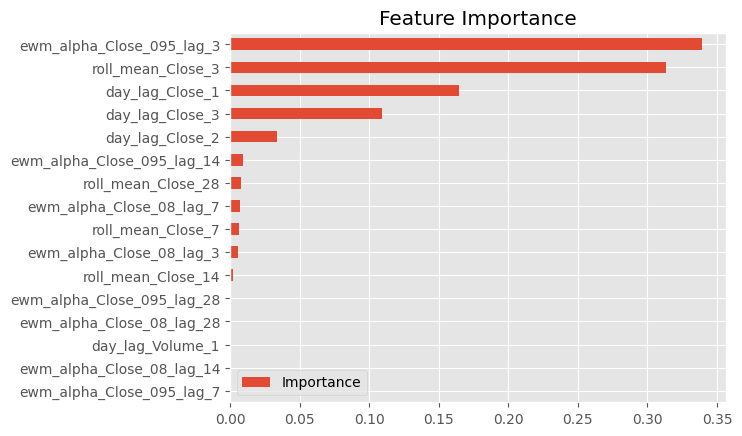

In [ ]:
((pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns=['Importance'])) \
    .sort_values('Importance')) \
    .plot(kind='barh', title = 'Feature Importance');

There is no importance for lag features more than 3 days

In [ ]:
y_pred = model.predict(X_test)
y_test.shape, y_pred.shape

((889,), (889,))

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("mse:", mse)
print("mape:", mape)
print("rmse:", rmse)

mse: 470578.7147616488
mape: 0.03471548644534204
rmse: 685.9874013140831


In [ ]:
# Save Model
train_checkpoints = "/content/drive/MyDrive/Colab Notebooks/Crypto Project/training checkpoints"
model.save_model(f"{train_checkpoints}/btc_model_1.ubj")

# Load Model
loaded_model = Booster(model_file=None)
loaded_model.load_model(f"{train_checkpoints}/btc_model_1.ubj")
mean_absolute_percentage_error(y_pred, loaded_model.predict(DMatrix(X_test))) # a small error while predicting, which is acceptable!

0.0016057843

# Add more relevant features

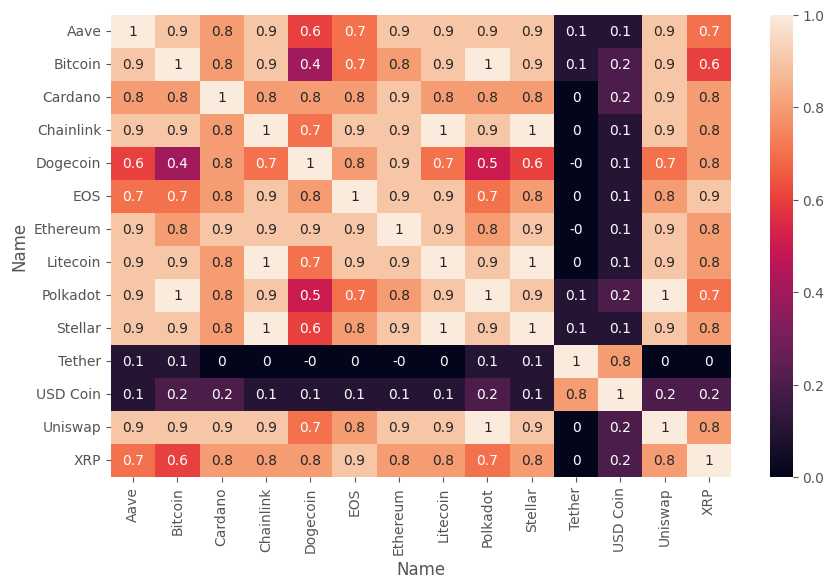

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(crypto_corr, annot=True);

In [13]:
'''
    Our forecasting horizon is 15 days,
    hence for lag of days, we'll compute iteratively from previous predictions.
'''

def createLagFeatures(data, feature_name, n=3):
    ''' Lag Features '''
    for i in range(1, n+1):
        data[f'day_lag_{feature_name}_{i}'] = data[feature_name].shift(i)

def random_noise(data):
    return np.random.normal(scale=1.5, size=(len(data)))
def createRollMeanFeatures(data, feature_name, windows):
    ''' Roll mean Features '''
    for window in windows:
        data[f'roll_mean_{feature_name}_' + str(window)] = data[feature_name].shift(1).rolling(window=window, win_type="triang").mean() + random_noise(data)

def createEWMFeatures(data, feature_name, alphas, lags):
    ''' Exponential Weighted Moving Average '''
    for alpha in alphas:
        for lag in lags:
            data[f'ewm_alpha_{feature_name}_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = data[feature_name].shift(lag).ewm(alpha=alpha).mean()

def createMACDFeature(data, feature_name, alpha="auto", ShortEMA_n=14, LongEMA_n=28, Signal_n=9):
    ''' MACD '''
    temp = data.copy()

    if alpha=='auto':
        sh_alpha = 2/(ShortEMA_n+1)
        lo_alpha = 2/(LongEMA_n+1)
        si_alpha = 2/(Signal_n+1)
    else:
        sh_alpha = lo_alpha = si_alpha = alpha

    ShortEMA_col = f'ewm_alpha_{feature_name}_' + str(sh_alpha).replace(".", "") + "_lag_" + str(ShortEMA_n)
    LongEMA_col = f'ewm_alpha_{feature_name}_' + str(lo_alpha).replace(".", "") + "_lag_" + str(LongEMA_n)

    # Check or Create ShortEMA
    if not ShortEMA_col in temp.columns:
        temp[ShortEMA_col] = temp[feature_name].shift(ShortEMA_n).ewm(alpha=sh_alpha).mean()

    # Check or Create LongEMA
    if not LongEMA_col in temp.columns:
        temp[LongEMA_col] = temp[feature_name].shift(LongEMA_n).ewm(alpha=lo_alpha).mean()

    # MACD Line
    temp["MACDLine"] = temp[ShortEMA_col] - temp[LongEMA_col]

    # Signal Line
    temp["SignalLine"] = temp["MACDLine"].shift(Signal_n).ewm(alpha=si_alpha).mean()

    # MACD Histogram
    temp["MACDHistogram"] = temp["MACDLine"] - temp["SignalLine"]

    data["MACDHistogram"] = temp["MACDHistogram"]

def createFeatures (data, rmNan=True):

    temp = data.copy()
    temp = temp[::-1] #reverse the df

    createLagFeatures(temp, 'Close')
    #createRollMeanFeatures(temp, 'Close', windows=[3,7])
    #createEWMFeatures(temp, 'Close', alphas=[0.95,0.8], lags=[3,7])
    createRollMeanFeatures(temp, 'Close', windows=[3,7,14,28])
    createEWMFeatures(temp, 'Close', alphas=[0.95,0.8], lags=[3,7,14,28])

    createMACDFeature(temp, 'Close')

    createLagFeatures(temp, 'Volume', n=1)
    temp = temp.drop('Volume', axis=1)

    # Treat NaN records
    if rmNan:
        temp = temp.dropna()
    else:
        temp = temp.bfill()

    temp = temp[::-1] #reverse the df again
    return temp

def includeOtherCoins (data, current_coin, rmNan=True):

    temp = data.copy()

    for coin in coins:
        if coin != current_coin:
            if crypto_corr[crypto_corr.index == current_coin][coin][current_coin] >= 0.8:
                locals()[coin+"_df"] = coin_df(coin)[['Close']].rename(columns={'Close': f'{coin}_Close'})
                locals()[coin+"_df"].index = locals()[coin+"_df"].index + pd.DateOffset(days=1) # 1 Day lag

                temp = temp.merge(locals()[coin+"_df"], how='left', on='Date')

    # Treat NaN records
    if rmNan:
        temp = temp.dropna()
    else:
        temp = temp.fillna(-1)

    return temp

In [14]:
newbitcoin_df_2 = createFeatures(bitcoin_df, False)
newbitcoin_df_2 = includeOtherCoins(newbitcoin_df_2, 'Bitcoin', False)
newbitcoin_df_2

,Close,day_lag_Close_1,day_lag_Close_2,day_lag_Close_3,roll_mean_Close_3,roll_mean_Close_7,roll_mean_Close_14,roll_mean_Close_28,ewm_alpha_Close_095_lag_3,ewm_alpha_Close_095_lag_7,ewm_alpha_Close_095_lag_14,ewm_alpha_Close_095_lag_28,ewm_alpha_Close_08_lag_3,ewm_alpha_Close_08_lag_7,ewm_alpha_Close_08_lag_14,ewm_alpha_Close_08_lag_28,MACDHistogram,day_lag_Volume_1,Aave_Close,Cardano_Close,Chainlink_Close,Ethereum_Close,Litecoin_Close,Polkadot_Close,Stellar_Close,Uniswap_Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-06,34235.193450,33746.002460,35287.779770,34668.548400,34747.569651,34408.659358,34194.645015,35118.527497,34629.349394,35796.333472,32474.257004,33482.760014,34513.847632,35570.009221,32501.114459,33582.603713,4838.110143,2.672155e+10,307.829079,1.404898,18.371589,2198.582464,138.073246,15.235582,0.254456,20.095181
2021-07-05,33746.002460,35287.779770,34668.548400,33897.048590,34630.212436,34493.978638,33989.775104,35328.327315,33884.568279,34438.892386,31877.603507,33675.197034,33895.044562,34378.935145,32482.933014,34022.491567,5446.167534,2.492431e+10,277.038792,1.458184,19.262838,2321.724112,144.905849,16.014026,0.268128,20.771874
2021-07-04,35287.779770,34668.548400,33897.048590,33572.117650,34007.489440,34657.390168,33767.935094,35548.106269,33647.442371,34525.476820,35694.889277,35850.491712,33887.028449,34157.334485,35707.890149,35869.626475,6146.594559,2.438396e+10,259.655225,1.406836,18.538818,2226.114282,140.279688,15.553716,0.264324,19.524757
2021-07-03,34668.548400,33897.048590,33572.117650,35040.837250,34022.081587,34650.524380,33624.430925,35767.767370,35078.612061,32166.289198,35630.153180,35624.657375,35146.671644,32188.094063,35746.264983,35898.621457,6458.696643,3.872897e+10,233.948437,1.394397,18.283561,2150.040364,136.943696,15.340774,0.263427,18.241726
2021-07-02,33897.048590,33572.117650,35040.837250,35867.777740,34881.353959,34310.915998,33606.868905,35979.459940,35796.333472,31786.508238,35901.547470,37005.931632,35570.009221,32195.359633,36267.847836,37285.272364,6693.594233,3.783896e+10,231.626362,1.335611,18.273293,2113.605523,137.577528,15.278964,0.269746,17.870399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-03,97.750000,105.209999,116.989998,139.000000,118.405638,114.839879,109.375381,117.273179,139.263809,144.539993,144.539993,144.539993,139.923332,144.539993,144.539993,144.539993,33.605197,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,3.371980,-1.000000,-1.000000,-1.000000
2013-05-02,105.209999,116.989998,139.000000,144.539993,136.623053,114.839879,109.375381,117.273179,144.539993,144.539993,144.539993,144.539993,144.539993,144.539993,144.539993,144.539993,33.605197,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,3.801010,-1.000000,-1.000000,-1.000000
2013-05-01,116.989998,139.000000,144.539993,144.539993,136.623053,114.839879,109.375381,117.273179,144.539993,144.539993,144.539993,144.539993,144.539993,144.539993,144.539993,144.539993,33.605197,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,4.296490,-1.000000,-1.000000,-1.000000


In [ ]:
X = newbitcoin_df_2.drop('Close', axis=1)
y = newbitcoin_df_2['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2093, 24), (898, 24), (2093,), (898,))

### Feature Selection

In [ ]:
VarianceThreshold?

In [ ]:
from sklearn.feature_selection import VarianceThreshold
VarThres = VarianceThreshold(threshold = 5) # Variance below 5 will be False
VarThres.fit(X)

VarThres_scores = pd.Series(VarThres.get_support())
VarThres_scores.index = X.columns
VarThres_scores.sort_values(ascending=False, inplace=True)
VarThres_scores

day_lag_Close_1                True
ewm_alpha_Close_08_lag_3       True
Polkadot_Close                 True
Litecoin_Close                 True
Ethereum_Close                 True
Chainlink_Close                True
Aave_Close                     True
day_lag_Volume_1               True
ewm_alpha_Close_08_lag_28      True
ewm_alpha_Close_08_lag_14      True
day_lag_Close_2                True
ewm_alpha_Close_08_lag_7       True
ewm_alpha_Close_095_lag_28     True
ewm_alpha_Close_095_lag_14     True
ewm_alpha_Close_095_lag_7      True
ewm_alpha_Close_095_lag_3      True
roll_mean_Close_28             True
roll_mean_Close_14             True
roll_mean_Close_7              True
roll_mean_Close_3              True
day_lag_Close_3                True
Uniswap_Close                  True
Cardano_Close                 False
Stellar_Close                 False
dtype: bool

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
np.random.seed(42)
f_select = SelectKBest(f_regression, k=10)  # k: Number of top features to select
kBest_f_reg = f_select.fit(X, y)
f_reg_scores = pd.Series(f_select.scores_)
f_reg_scores.index = X.columns
f_reg_scores.sort_values(ascending=False, inplace=True)
f_reg_scores

day_lag_Close_1               1.100117e+06
roll_mean_Close_3             7.194052e+05
day_lag_Close_2               5.910235e+05
day_lag_Close_3               3.832318e+05
ewm_alpha_Close_095_lag_3     3.824152e+05
ewm_alpha_Close_08_lag_3      3.748152e+05
roll_mean_Close_7             3.511444e+05
roll_mean_Close_14            1.736628e+05
ewm_alpha_Close_095_lag_7     1.474602e+05
ewm_alpha_Close_08_lag_7      1.460890e+05
roll_mean_Close_28            8.837449e+04
ewm_alpha_Close_095_lag_14    6.854513e+04
ewm_alpha_Close_08_lag_14     6.833487e+04
ewm_alpha_Close_095_lag_28    3.486545e+04
ewm_alpha_Close_08_lag_28     3.471276e+04
Chainlink_Close               2.343590e+04
Polkadot_Close                1.674321e+04
Ethereum_Close                1.443423e+04
Uniswap_Close                 1.336555e+04
Aave_Close                    1.313823e+04
Litecoin_Close                5.670754e+03
day_lag_Volume_1              5.620727e+03
Cardano_Close                 5.579974e+03
Stellar_Clo

In [ ]:
from sklearn.feature_selection import mutual_info_regression
np.random.seed(42)
f_select = SelectKBest(mutual_info_regression, k=10)
kBest_mutual_info_reg = f_select.fit(X, y)
mutual_info_reg_scores = pd.Series(f_select.scores_)
mutual_info_reg_scores.index = X.columns
mutual_info_reg_scores.sort_values(ascending=False, inplace=True)
mutual_info_reg_scores

day_lag_Close_1               3.506443
roll_mean_Close_3             3.240130
day_lag_Close_2               3.139393
roll_mean_Close_7             2.996547
ewm_alpha_Close_08_lag_3      2.972339
ewm_alpha_Close_095_lag_3     2.969252
day_lag_Close_3               2.967034
roll_mean_Close_14            2.795964
ewm_alpha_Close_08_lag_7      2.688042
roll_mean_Close_28            2.665048
ewm_alpha_Close_095_lag_7     2.655275
ewm_alpha_Close_08_lag_14     2.479190
ewm_alpha_Close_095_lag_14    2.459586
ewm_alpha_Close_08_lag_28     2.311264
ewm_alpha_Close_095_lag_28    2.283325
Litecoin_Close                1.929256
Ethereum_Close                1.821758
Stellar_Close                 1.773670
day_lag_Volume_1              1.519751
Chainlink_Close               1.279779
Cardano_Close                 1.265511
Polkadot_Close                0.423531
Uniswap_Close                 0.393050
Aave_Close                    0.381817
dtype: float64

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

rfecv = RFECV(estimator=RandomForestRegressor(), cv=10, verbose=4)
rfecv.fit(X, y)

for i,col in enumerate(X.columns):
    print(f"{col}, selected={rfecv.support_[i]} ranking={rfecv.ranking_[i]}")

day_lag_Close_1, selected=True ranking=1
day_lag_Close_2, selected=False ranking=5
day_lag_Close_3, selected=False ranking=10
roll_mean_Close_3, selected=False ranking=4
roll_mean_Close_7, selected=True ranking=1
roll_mean_Close_14, selected=False ranking=2
roll_mean_Close_28, selected=True ranking=1
ewm_alpha_Close_095_lag_3, selected=False ranking=8
ewm_alpha_Close_095_lag_7, selected=False ranking=7
ewm_alpha_Close_095_lag_14, selected=False ranking=9
ewm_alpha_Close_095_lag_28, selected=False ranking=17
ewm_alpha_Close_08_lag_3, selected=False ranking=6
ewm_alpha_Close_08_lag_7, selected=False ranking=3
ewm_alpha_Close_08_lag_14, selected=False ranking=13
ewm_alpha_Close_08_lag_28, selected=False ranking=15
day_lag_Volume_1, selected=False ranking=14
Aave_Close, selected=False ranking=16
Cardano_Close, selected=False ranking=22
Chainlink_Close, selected=False ranking=19
Ethereum_Close, selected=False ranking=20
Litecoin_Close, selected=False ranking=18
Polkadot_Close, selected=Fals

# Hyper-Parameter Tunning Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyper Parameters
param_grid = {
    'n_estimators': [100, 500, 1000],
    'eta': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 20],
    'gamma': [0, 1, 5, 10],
    'subsample': [0.5, 0.6, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 1.0]
}

# Create an XGBoostRegressor model
model = XGBRegressor(eval_metric='rmse', early_stopping_rounds=50, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

Streaming output truncated to the last 5000 lines.
[40]	validation_0-rmse:425.44108	validation_1-rmse:624.76029
[50]	validation_0-rmse:413.43034	validation_1-rmse:621.93892
[60]	validation_0-rmse:407.92153	validation_1-rmse:625.15343
[70]	validation_0-rmse:399.34576	validation_1-rmse:624.61867
[79]	validation_0-rmse:394.82571	validation_1-rmse:623.54105
[0]	validation_0-rmse:10728.05243	validation_1-rmse:10491.72771
[10]	validation_0-rmse:1456.30675	validation_1-rmse:1568.84849
[20]	validation_0-rmse:520.54780	validation_1-rmse:741.93970
[30]	validation_0-rmse:392.40915	validation_1-rmse:677.18136
[40]	validation_0-rmse:349.62442	validation_1-rmse:677.43537
[50]	validation_0-rmse:333.69966	validation_1-rmse:679.96928
[60]	validation_0-rmse:325.12379	validation_1-rmse:678.71939
[70]	validation_0-rmse:316.26943	validation_1-rmse:676.19437
[80]	validation_0-rmse:308.48861	validation_1-rmse:676.50891
[89]	validation_0-rmse:304.59282	validation_1-rmse:675.96471
[0]	validation_0-rmse:10699.9

In [ ]:
# Get the best hyperparameters and best estimator from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
# You can then use the best model for predictions
y_pred = best_model.predict(X_test)

In [ ]:
XGBRegressor?

In [ ]:
grid_search

In [ ]:
model = XGBRegressor(n_estimators=1000, eta=0.01, gamma=10)
model.set_params(eval_metric='rmse', early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=100)

[0]	validation_0-rmse:13102.05985	validation_1-rmse:12796.32207
[100]	validation_0-rmse:4940.78456	validation_1-rmse:4896.14739
[200]	validation_0-rmse:1917.74453	validation_1-rmse:1969.20329
[300]	validation_0-rmse:809.76714	validation_1-rmse:993.65577
[400]	validation_0-rmse:402.04147	validation_1-rmse:724.35642
[500]	validation_0-rmse:250.96950	validation_1-rmse:667.63578
[600]	validation_0-rmse:189.13999	validation_1-rmse:652.69475
[700]	validation_0-rmse:154.79152	validation_1-rmse:648.95384
[722]	validation_0-rmse:150.07664	validation_1-rmse:648.95103


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric='rmse',
             feature_types=None, gamma=10, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

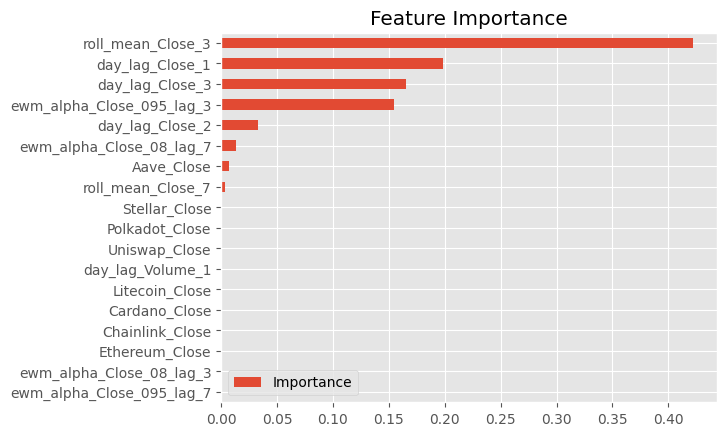

In [ ]:
((pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns=['Importance'])) \
    .sort_values('Importance')) \
    .plot(kind='barh', title = 'Feature Importance');

There is no importance for lag features more than 3 days

In [ ]:
y_pred = model.predict(X_test)
y_test.shape, y_pred.shape

((889,), (889,))

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("mse:", mse)
print("mape:", mape)
print("rmse:", rmse)

mse: 401371.07876087015
mape: 0.03527136401981214
rmse: 633.5385377077469


In [ ]:
# Save Model
train_checkpoints = "/content/drive/MyDrive/Colab Notebooks/Crypto Project/training checkpoints"
model.save_model(f"{train_checkpoints}/btc_model_2.ubj")

0.0016057843